In [24]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
sales_of_company_x = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("daily-total-female-births-in-cal.csv")

In [26]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

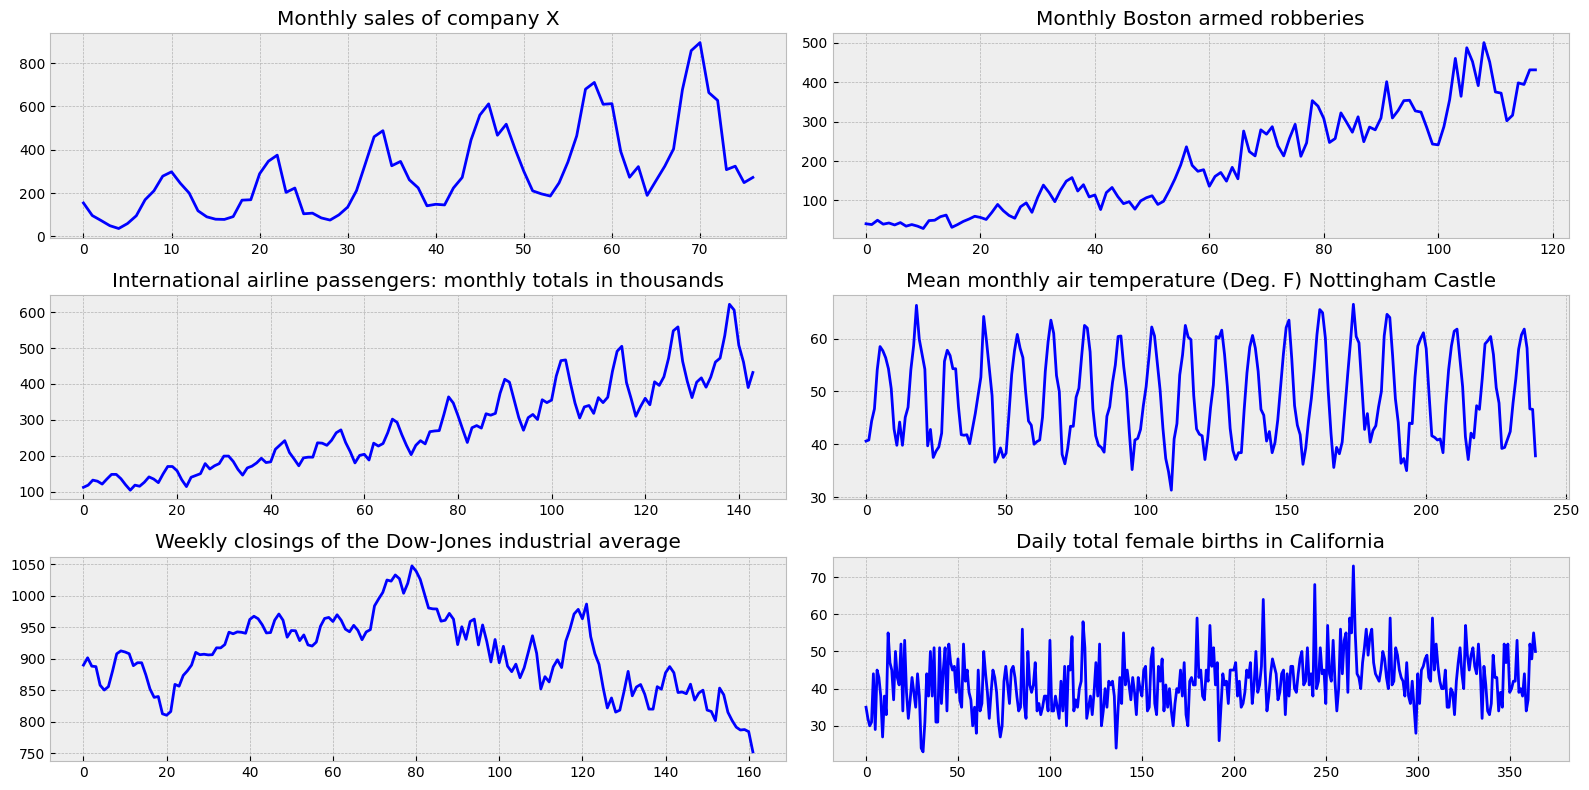

In [28]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

In [29]:
def plot_ts_and_points(ts, start_point, step):
    new_series = [None for i in range(len(ts))]
    for i in range(len(ts)):
        pos = start_point + step * i
        if pos >= len(ts):
            break
        new_series[pos] = ts[pos]
    new_series = pd.Series(new_series)

    with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        ts_ax = plt.axes()
        ts.plot(ax=ts_ax, color='blue')
        new_series.plot(ax=ts_ax, style='ro')

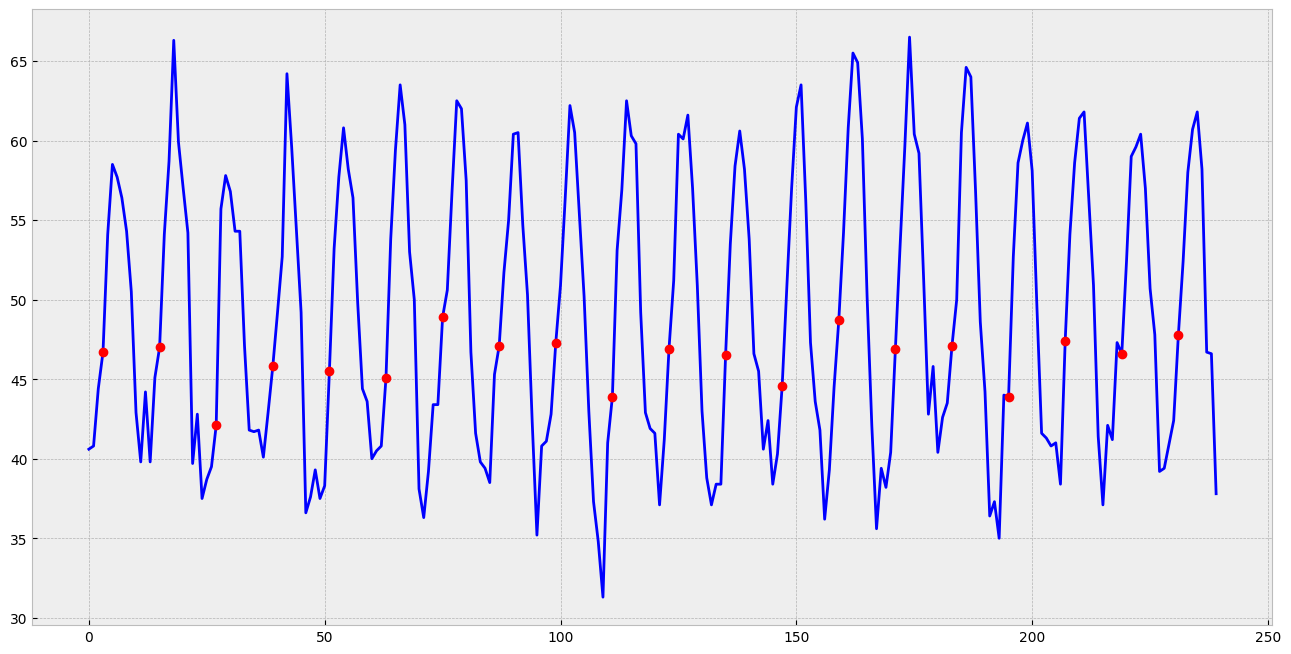

In [30]:
# Примеры поиска сезонности

plot_ts_and_points(mean_monthly_temp["Deg"], 3, 12)

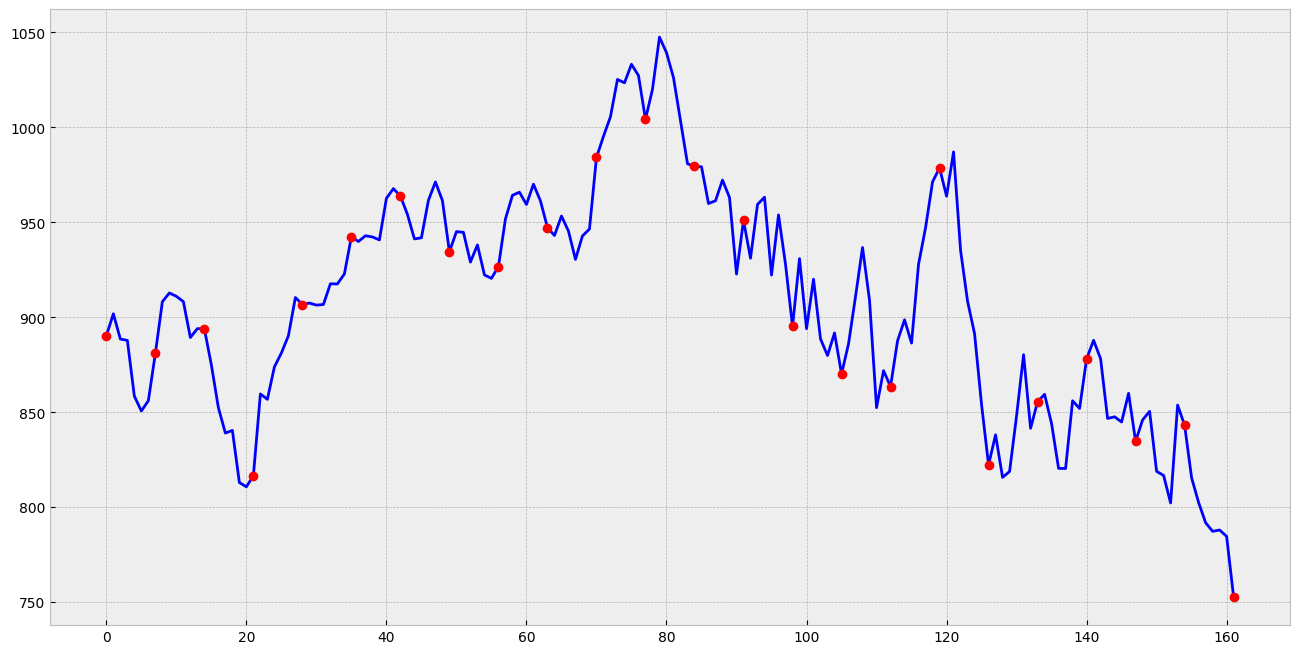

In [31]:
plot_ts_and_points(dowjones_closing["Close"], 0, 7)

## Нормализуем дисперсию

In [32]:
boxcox_series = dict()

for key in all_series.keys():
  boxcox_series[key] = boxcox(all_series[key], 0)

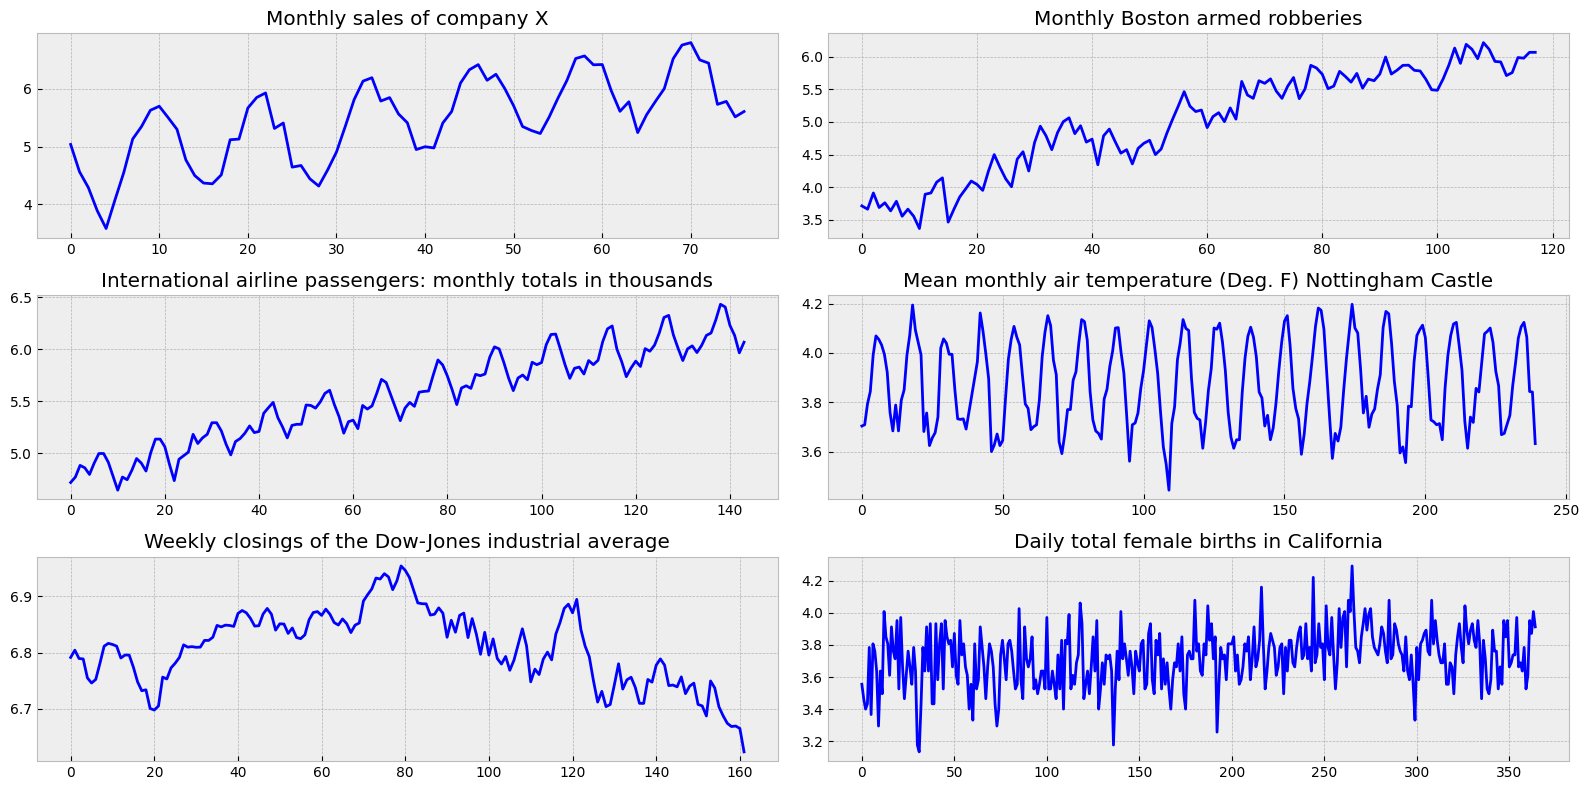

In [34]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(boxcox_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        pd.Series(boxcox_series[key]).plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

## Дифференцируем

In [37]:
diff_series = dict()

for key in boxcox_series.keys():
    diff_series[key] = np.diff(boxcox_series[key], 1)

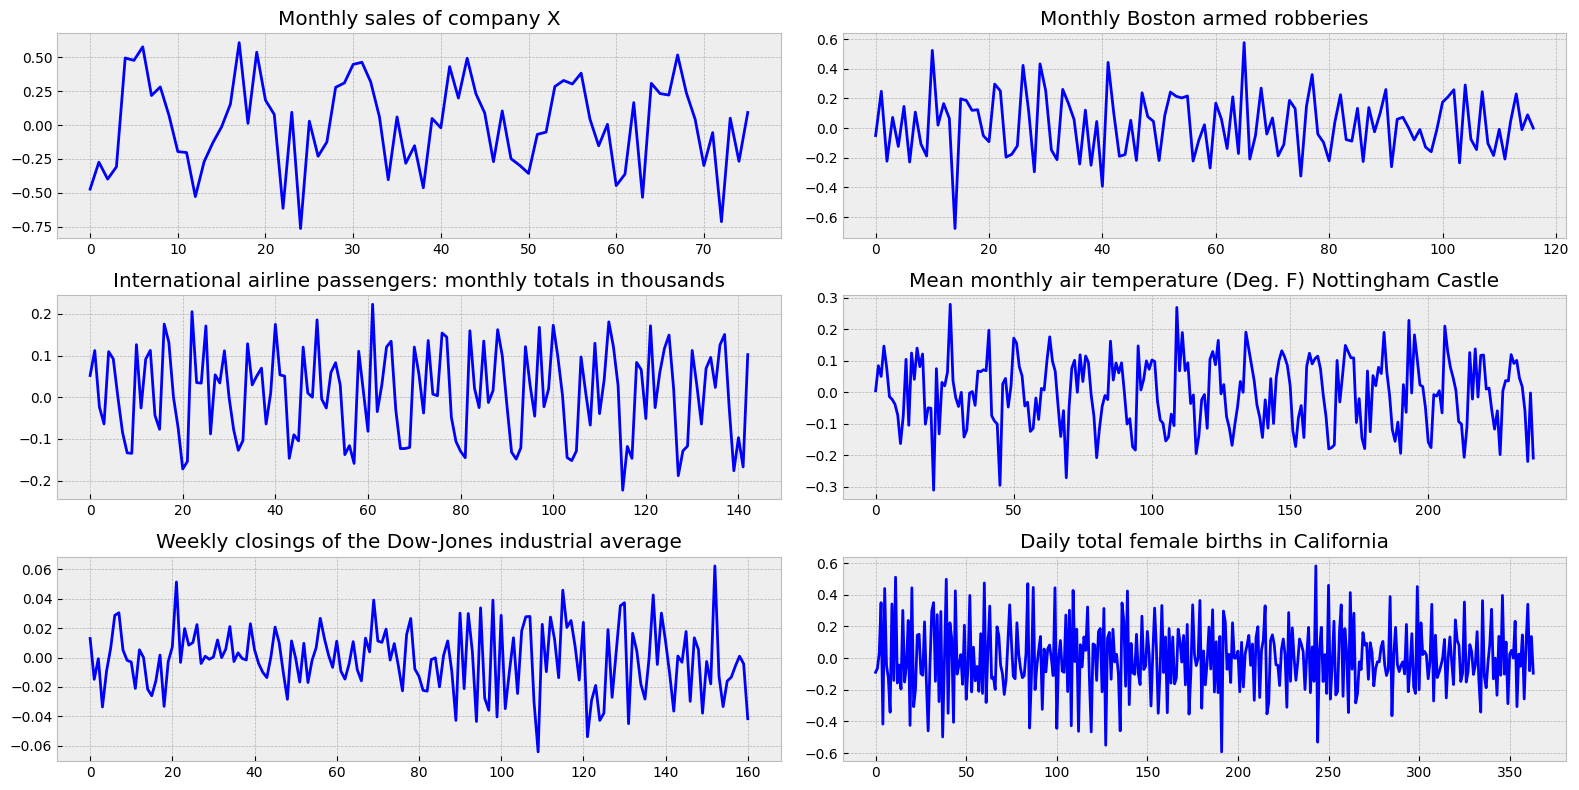

In [39]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(diff_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        pd.Series(diff_series[key]).plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

In [40]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [45]:
for key in diff_series.keys():
    print(f"Series: {key}")
    test_stationarity(diff_series[key])
    print("-" * 40)

Series: Monthly sales of company X
Results of Dickey-Fuller Test:
Test Statistic                 -3.135644
p-value                         0.024025
#Lags Used                     11.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64
----------------------------------------
Series: Monthly Boston armed robberies
Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64
----------------------------------------
Series: International airline passengers: monthly totals in thousands
Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value       

Поскольку p-value для Series: International airline passengers: monthly totals in thousands больше 0.05, можно попробовать этот ряд дифференцировать с разными лагами:

In [59]:
for i in range(1, 13):
  series = pd.Series(boxcox_series["International airline passengers: monthly totals in thousands"]).diff(i).dropna().values
  print(f"Lag: {i}")
  test_stationarity(series)
  print("-" * 40)

Lag: 1
Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64
----------------------------------------
Lag: 2
Results of Dickey-Fuller Test:
Test Statistic                  -3.167907
p-value                          0.021919
#Lags Used                      11.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
----------------------------------------
Lag: 3
Results of Dickey-Fuller Test:
Test Statistic                  -2.728487
p-value                          0.069237
#Lags Used                      12.000000
Number of Observations Used    128.000000
Critical Value (1%

Наименьший p-value для Series: International airline passengers: monthly totals in thousands получился с лагом = 9